In [1]:
#import dependecies
import pandas as pd
import sqlite3
import warnings
warnings.filterwarnings('ignore')

import datetime
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

#import dependencies for ML models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVR
from sklearn.model_selection import validation_curve
import math
from math import sqrt


#import dependencies for graphs
import numpy as np
import matplotlib.pyplot as plt 
from scipy import stats
import seaborn as sns; sns.set_theme(color_codes=True)
sns.set_context("paper")


In [2]:
#connect to a sqlite3 db
conn = sqlite3.connect(r'/Users/rosaicelaroman/Desktop/portfolio_work/earthquake_modeling/Database/db/earthquake_db')
print("Connected to database...")

Connected to database...


In [3]:
#create dataframe reading all rows from sqlite database
model_df = pd.read_sql_query("SELECT * FROM earthquake_raw", conn)
model_df

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-01-06T01:42:39.855Z,37.3840,-117.107500,1.10,1.30,ml,8.0,149.46,0.87500,0.2175,...,2022-01-06T01:47:19.317Z,"37 km SSE of Goldfield, Nevada",earthquake,NaN,39.10,0.290,4.0,automatic,nn,nn
1,2022-01-06T01:31:33.698Z,38.1810,-117.818000,7.30,1.40,ml,11.0,154.64,0.11900,0.1017,...,2022-01-06T01:47:40.245Z,"34 km SE of Mina, Nevada",earthquake,NaN,2.00,0.460,5.0,automatic,nn,nn
2,2022-01-06T01:24:20.083Z,61.3407,-149.885200,30.00,1.50,ml,NaN,NaN,NaN,0.7500,...,2022-01-06T01:29:22.015Z,"5 km ESE of Point MacKenzie, Alaska",earthquake,NaN,0.20,NaN,NaN,automatic,ak,ak
3,2022-01-06T01:15:15.851Z,62.8703,-150.762500,111.30,2.10,ml,NaN,NaN,NaN,0.3200,...,2022-01-06T01:29:21.875Z,"41 km N of Petersville, Alaska",earthquake,NaN,0.80,NaN,NaN,automatic,ak,ak
4,2022-01-06T01:10:44.629Z,64.0145,-148.765700,1.90,1.50,ml,NaN,NaN,NaN,0.7200,...,2022-01-06T01:15:56.292Z,"17 km E of Ferry, Alaska",earthquake,NaN,0.60,NaN,NaN,automatic,ak,ak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33889,2022-02-15T19:12:23.740Z,39.4215,-110.312333,-1.56,1.83,md,9.0,194.00,0.01022,0.1200,...,2022-02-15T19:51:17.520Z,"15 km SSE of Sunnyside, Utah",earthquake,0.63,0.36,0.324,7.0,reviewed,uu,uu
33890,2022-02-15T19:04:27.070Z,38.8250,-122.797167,2.68,0.41,md,25.0,44.00,0.01021,0.0300,...,2022-02-17T09:24:12.854Z,"6km NNW of The Geysers, CA",earthquake,0.18,0.28,0.129,3.0,reviewed,nc,nc
33891,2022-02-15T19:00:38.627Z,38.5375,-119.382100,0.00,1.40,ml,6.0,179.74,0.05500,0.1995,...,2022-02-16T02:37:07.010Z,"8 km ENE of Walker, California",earthquake,NaN,0.00,0.280,3.0,reviewed,nn,nn
33892,2022-02-15T18:52:46.384Z,55.3724,-159.286100,15.00,1.80,ml,NaN,NaN,NaN,0.5500,...,2022-03-05T17:45:05.111Z,"60 km SSE of Ivanof Bay, Alaska",earthquake,NaN,0.40,NaN,NaN,reviewed,ak,ak


In [4]:
#converting time to datetime
model_df['time'] = pd.to_datetime(model_df['time'])
model_df

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-01-06 01:42:39.855000+00:00,37.3840,-117.107500,1.10,1.30,ml,8.0,149.46,0.87500,0.2175,...,2022-01-06T01:47:19.317Z,"37 km SSE of Goldfield, Nevada",earthquake,NaN,39.10,0.290,4.0,automatic,nn,nn
1,2022-01-06 01:31:33.698000+00:00,38.1810,-117.818000,7.30,1.40,ml,11.0,154.64,0.11900,0.1017,...,2022-01-06T01:47:40.245Z,"34 km SE of Mina, Nevada",earthquake,NaN,2.00,0.460,5.0,automatic,nn,nn
2,2022-01-06 01:24:20.083000+00:00,61.3407,-149.885200,30.00,1.50,ml,NaN,NaN,NaN,0.7500,...,2022-01-06T01:29:22.015Z,"5 km ESE of Point MacKenzie, Alaska",earthquake,NaN,0.20,NaN,NaN,automatic,ak,ak
3,2022-01-06 01:15:15.851000+00:00,62.8703,-150.762500,111.30,2.10,ml,NaN,NaN,NaN,0.3200,...,2022-01-06T01:29:21.875Z,"41 km N of Petersville, Alaska",earthquake,NaN,0.80,NaN,NaN,automatic,ak,ak
4,2022-01-06 01:10:44.629000+00:00,64.0145,-148.765700,1.90,1.50,ml,NaN,NaN,NaN,0.7200,...,2022-01-06T01:15:56.292Z,"17 km E of Ferry, Alaska",earthquake,NaN,0.60,NaN,NaN,automatic,ak,ak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33889,2022-02-15 19:12:23.740000+00:00,39.4215,-110.312333,-1.56,1.83,md,9.0,194.00,0.01022,0.1200,...,2022-02-15T19:51:17.520Z,"15 km SSE of Sunnyside, Utah",earthquake,0.63,0.36,0.324,7.0,reviewed,uu,uu
33890,2022-02-15 19:04:27.070000+00:00,38.8250,-122.797167,2.68,0.41,md,25.0,44.00,0.01021,0.0300,...,2022-02-17T09:24:12.854Z,"6km NNW of The Geysers, CA",earthquake,0.18,0.28,0.129,3.0,reviewed,nc,nc
33891,2022-02-15 19:00:38.627000+00:00,38.5375,-119.382100,0.00,1.40,ml,6.0,179.74,0.05500,0.1995,...,2022-02-16T02:37:07.010Z,"8 km ENE of Walker, California",earthquake,NaN,0.00,0.280,3.0,reviewed,nn,nn
33892,2022-02-15 18:52:46.384000+00:00,55.3724,-159.286100,15.00,1.80,ml,NaN,NaN,NaN,0.5500,...,2022-03-05T17:45:05.111Z,"60 km SSE of Ivanof Bay, Alaska",earthquake,NaN,0.40,NaN,NaN,reviewed,ak,ak


In [5]:
#review names of all columns (features)
for col in model_df.columns:
    print(col)

time
latitude
longitude
depth
mag
magType
nst
gap
dmin
rms
net
id
updated
place
type
horizontalError
depthError
magError
magNst
status
locationSource
magSource


In [6]:
#drop columns not needed
cleaned_df = model_df.drop(columns=['id', 'nst','rms','magNst','net', 'time', 'magType', 'gap','dmin', 'updated', 'place', 'type', 'horizontalError', 'depthError', 'magError', 'status', 'locationSource', 'magSource'])
cleaned_df

,latitude,longitude,depth,mag
0,37.3840,-117.107500,1.10,1.30
1,38.1810,-117.818000,7.30,1.40
2,61.3407,-149.885200,30.00,1.50
3,62.8703,-150.762500,111.30,2.10
4,64.0145,-148.765700,1.90,1.50
...,...,...,...,...
33889,39.4215,-110.312333,-1.56,1.83
33890,38.8250,-122.797167,2.68,0.41
33891,38.5375,-119.382100,0.00,1.40
33892,55.3724,-159.286100,15.00,1.80


In [7]:
#find if any column has NaNs
cleaned_df.isnull().sum()

latitude     0
longitude    0
depth        0
mag          6
dtype: int64

In [8]:
#drop NaNs
cleaned_df_dropped = cleaned_df.dropna()

In [9]:
#verify dropped NaNs
cleaned_df_dropped.isnull().sum()

latitude     0
longitude    0
depth        0
mag          0
dtype: int64

In [10]:
#establish features to be used in model. X will use: latitude, longitude, depth and unix time. Y will be magnitude
X = cleaned_df_dropped.drop(['mag'], axis = 1)

y = cleaned_df_dropped[['mag']]

In [11]:
#checking number of columns and rows for each feature
X.shape, y.shape

((33888, 3), (33888, 1))

In [12]:
#scale and transform the data
# sc_X = StandardScaler()
# sc_y = StandardScaler()
# X = X.fit_transform(X)
# y = y.fit_transform(y)

In [13]:
#split dataset into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

Extra Trees Regressor

In [14]:
#create and run model: First with 50 estimators
scores = []
estimators_lst=[]

for i in range(1,50):
    model = ExtraTreesRegressor(n_estimators=i+1, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test,y_pred)

    r2 = r2_score(y_test, y_pred)
    score = model.score(X_test, y_test)
    estimators = i+1
    scores.append(score)
    estimators_lst.append(score)

    print("n_estimators={}:".format(estimators))
    print("\tMean Squared Error:", mse, end = ", ")
    print("\tR2 score:", r2, end = ", ")
    print("\tModel score:", score)
max_score = max(scores)
print("Max score:", max_score)
index_max_score = scores.index(max_score) #find the position in the list for max score to get the number of estimators
best_score = max_score
best_model = ExtraTreesRegressor(n_estimators=index_max_score+2, random_state=0)
best_model.fit(X_train, y_train)
best_model_score = best_model.score(X_test, y_test)
print("Best model score: ", best_model_score)


n_estimators=2:
	Mean Squared Error: 0.33639150127970335, 	R2 score: 0.7940848357291628, 	Model score: 0.7940848357291628
n_estimators=3:
	Mean Squared Error: 0.30591187310827683, 	R2 score: 0.8127423155345601, 	Model score: 0.8127423155345601
n_estimators=4:
	Mean Squared Error: 0.29011086375347334, 	R2 score: 0.8224145796213809, 	Model score: 0.8224145796213809
n_estimators=5:
	Mean Squared Error: 0.2813153909342612, 	R2 score: 0.8277985480733716, 	Model score: 0.8277985480733716
n_estimators=6:
	Mean Squared Error: 0.27331359955737355, 	R2 score: 0.8326966806943346, 	Model score: 0.8326966806943346
n_estimators=7:
	Mean Squared Error: 0.27055182678783135, 	R2 score: 0.8343872433017595, 	Model score: 0.8343872433017595
n_estimators=8:
	Mean Squared Error: 0.26791877949524806, 	R2 score: 0.8359990092462694, 	Model score: 0.8359990092462694
n_estimators=9:
	Mean Squared Error: 0.2649261877738498, 	R2 score: 0.8378308629451976, 	Model score: 0.8378308629451976
n_estimators=10:
	Mean Squ

In [15]:
#create and run model: Now with 100 max estimators if no improvement of the score is found
scores = []
counter = 0
import time
start_time = time.perf_counter()
for i in range(1,100):
    model = ExtraTreesRegressor(n_estimators=i+1, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test,y_pred)

    r2 = r2_score(y_test, y_pred)
    score = model.score(X_test, y_test)
    estimators = i+1
    current_score = score
    num_estimators = estimators

    print("n_estimators={}:".format(estimators))
    print("\tMean Squared Error:", mse, end = ", ")
    print("\tR2:", r2, end = ", ")
    print("\tModel score:", score)
    if current_score > best_score:
        best_score = current_score
        best_model = model
        num_estimators=i+1
        print('Improvement found!')
        counter = 0
    else:
        counter += 1
    if counter > 60:
        break

end_time = time.perf_counter()
execution_time = end_time - start_time

print(f'Best score found: {best_score:.3f}.')
print(f'Number of estimators: {num_estimators}.')
print(f'Code execution time: {execution_time:.3f} seconds.')

n_estimators=2:
	Mean Squared Error: 0.33639150127970335, 	R2: 0.7940848357291628, 	Model score: 0.7940848357291628
n_estimators=3:
	Mean Squared Error: 0.30591187310827683, 	R2: 0.8127423155345601, 	Model score: 0.8127423155345601
n_estimators=4:
	Mean Squared Error: 0.29011086375347334, 	R2: 0.8224145796213809, 	Model score: 0.8224145796213809
n_estimators=5:
	Mean Squared Error: 0.2813153909342612, 	R2: 0.8277985480733716, 	Model score: 0.8277985480733716
n_estimators=6:
	Mean Squared Error: 0.27331359955737355, 	R2: 0.8326966806943346, 	Model score: 0.8326966806943346
n_estimators=7:
	Mean Squared Error: 0.27055182678783135, 	R2: 0.8343872433017595, 	Model score: 0.8343872433017595
n_estimators=8:
	Mean Squared Error: 0.26791877949524806, 	R2: 0.8359990092462694, 	Model score: 0.8359990092462694
n_estimators=9:
	Mean Squared Error: 0.2649261877738498, 	R2: 0.8378308629451976, 	Model score: 0.8378308629451976
n_estimators=10:
	Mean Squared Error: 0.26285516766330685, 	R2: 0.83909859

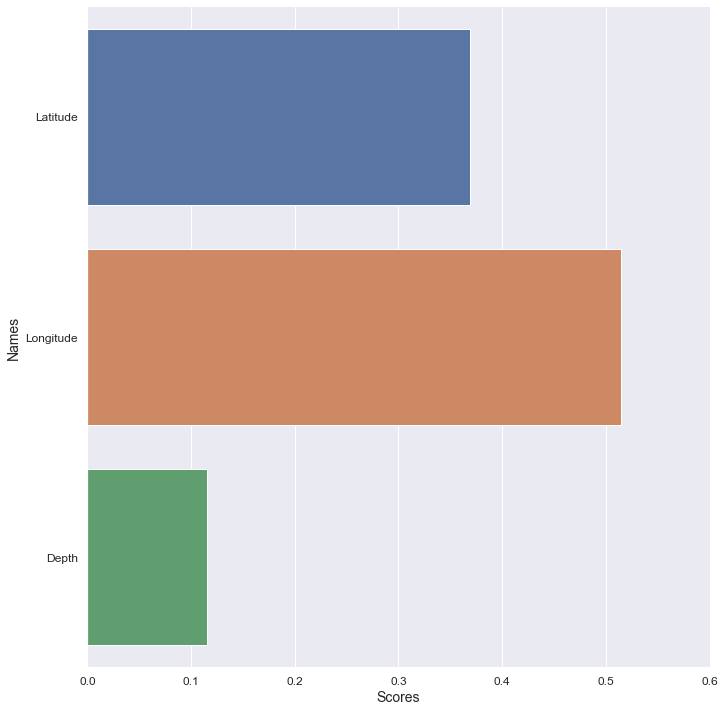

In [16]:
#visualize gini importance
features_lst = []
gini_score_lst = []
for feature, score in zip(cleaned_df_dropped[['latitude', 'longitude', 'depth']],best_model.feature_importances_):
    features_lst.append(feature)
    gini_score_lst.append(score)
feature_lst = [feature.capitalize() for feature in features_lst]
d = {'Names': feature_lst, 'Scores': gini_score_lst}
gini_df = pd.DataFrame(d)

sns.set()

p = sns.catplot(y='Names', x="Scores", data=gini_df, kind='bar', height=10, aspect=1, legend=False)
p.set_ylabels(fontsize=14)
p.set_yticklabels(fontsize=12)
p.set_xticklabels(fontsize=12)
p.set_xlabels(fontsize=14)
plt.show()

Cross-Validation

In [17]:
#define number of splits for cross-validation
k_fold = KFold(n_splits=10)
for train_indices, test_indices in k_fold.split(X):
    print('Train: %s | test: %s' % (train_indices, test_indices))


Train: [ 3389  3390  3391 ... 33885 33886 33887] | test: [   0    1    2 ... 3386 3387 3388]
Train: [    0     1     2 ... 33885 33886 33887] | test: [3389 3390 3391 ... 6775 6776 6777]
Train: [    0     1     2 ... 33885 33886 33887] | test: [ 6778  6779  6780 ... 10164 10165 10166]
Train: [    0     1     2 ... 33885 33886 33887] | test: [10167 10168 10169 ... 13553 13554 13555]
Train: [    0     1     2 ... 33885 33886 33887] | test: [13556 13557 13558 ... 16942 16943 16944]
Train: [    0     1     2 ... 33885 33886 33887] | test: [16945 16946 16947 ... 20331 20332 20333]
Train: [    0     1     2 ... 33885 33886 33887] | test: [20334 20335 20336 ... 23720 23721 23722]
Train: [    0     1     2 ... 33885 33886 33887] | test: [23723 23724 23725 ... 27109 27110 27111]
Train: [    0     1     2 ... 33885 33886 33887] | test: [27112 27113 27114 ... 30497 30498 30499]
Train: [    0     1     2 ... 30497 30498 30499] | test: [30500 30501 30502 ... 33885 33886 33887]


In [18]:
#calculate cross-validation score
from numpy import mean
from numpy import std

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cv_score=cross_val_score(best_model, X, y.values.ravel(), scoring='neg_mean_absolute_error', cv=k_fold, n_jobs=-1)
    print(cv_score)

# report performance
print('MAE: %.3f (%.3f)' % (mean(cv_score), std(cv_score)))

[-0.37251596 -0.37291058 -0.36405388 -0.37235388 -0.38527541 -0.36900366
 -0.37149571 -0.36084647 -0.35978332 -0.36610633]
MAE: -0.369 (0.007)


In [19]:
#define tree for plot validation curve
reg_etrees = ExtraTreesRegressor(n_estimators=100, random_state=0)

In [20]:
##create elements for plot validation curve
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html
param_range = np.linspace(1, 100, 5, dtype=int)
train_scores, test_scores = validation_curve(
    reg_etrees,
    X,
    y.values.ravel(),
    param_name="n_estimators",
    param_range=param_range,
    n_jobs=2,
    cv=10
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

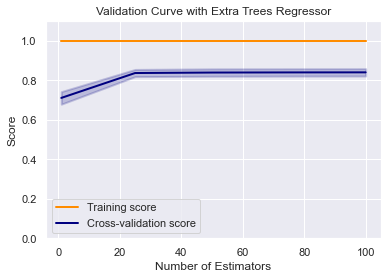

In [21]:
#plot validation curve
plt.title("Validation Curve with Extra Trees Regressor")
plt.xlabel("Number of Estimators")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.plot(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.plot(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="best")
plt.show()

In [22]:
#use the best model to make predictions
testpred = best_model.predict(X_test)
actual_mag = y_test
mags = actual_mag['mag'].tolist()
testpredict = []
abs_error = []
for item in testpred:
    testpredict.append(item)

maerr=mean_absolute_error(mags, testpredict)
test_mse = mean_squared_error(y_test, testpred)

test_mse = mean_squared_error(y_test, testpred)
rmse = sqrt(test_mse)
print('RMSE: %.3f' % rmse)
print('MAE: %.3f' % maerr)

RMSE: 0.496
MAE: 0.362


In [23]:
#make dataframe with actual test values and ML predicted ones
mag_pred = actual_mag
mag_pred['Predicted'] = testpredict


In [24]:
mag_pred_all = mag_pred.rename(columns={'mag': 'Actual'})
mag_pred_all

,Actual,Predicted
8338,1.38,1.2848
8426,5.40,4.3770
3079,0.30,0.5990
5192,0.65,0.8196
32429,5.10,4.8800
...,...,...
15274,2.00,2.1180
17005,1.57,1.6134
16140,1.10,0.8025
2461,1.40,1.4270


In [25]:
#join dataframes for actual and predicted with original dataframe
mag_pred_all = mag_pred.merge(model_df, how='inner', left_index=True, right_index=True)
mag_pred_all


,mag_x,Predicted,time,latitude,longitude,depth,mag_y,magType,nst,gap,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
8338,1.38,1.2848,2021-12-07 15:32:01.140000+00:00,36.562500,-121.142333,4.35,1.38,md,14.0,120.00,...,2021-12-14T06:11:11.550Z,"3km N of Pinnacles, CA",earthquake,0.28,1.49,0.327000,13.0,reviewed,nc,nc
8426,5.40,4.3770,2021-12-07 10:28:00.447000+00:00,-9.963400,161.043300,170.33,5.40,mww,NaN,25.00,...,2021-12-08T10:31:06.697Z,"110 km WNW of Kirakira, Solomon Islands",earthquake,4.70,5.80,0.098000,10.0,reviewed,us,us
3079,0.30,0.5990,2021-12-24 04:06:37.017000+00:00,40.160500,-119.622500,6.20,0.30,ml,3.0,241.35,...,2021-12-29T18:39:58.816Z,"23 km N of Sutcliffe, Nevada",earthquake,NaN,8.30,0.000000,1.0,reviewed,nn,nn
5192,0.65,0.8196,2021-12-17 20:17:55.100000+00:00,38.839832,-122.819336,1.36,0.65,md,22.0,56.00,...,2021-12-17T20:40:12.214Z,"9km WNW of Cobb, CA",earthquake,0.22,0.51,0.270000,4.0,automatic,nc,nc
32429,5.10,4.8800,2022-02-19 14:45:11.512000+00:00,-23.717300,-175.527600,10.00,5.10,mb,NaN,154.00,...,2022-02-19T15:03:02.040Z,"270 km SSW of ‘Ohonua, Tonga",earthquake,7.40,1.80,0.092000,38.0,reviewed,us,us
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15274,2.00,2.1180,2021-12-28 08:01:37.573000+00:00,59.876800,-153.452900,130.80,2.00,ml,NaN,NaN,...,2022-01-24T16:20:00.261Z,"37 km ENE of Pedro Bay, Alaska",earthquake,NaN,0.30,NaN,NaN,reviewed,ak,ak
17005,1.57,1.6134,2022-02-01 07:49:18.629000+00:00,36.842667,-97.798333,7.33,1.57,ml,69.0,86.00,...,2022-02-02T20:46:24.887Z,"6 km NW of Medford, Oklahoma",earthquake,NaN,0.50,0.250000,8.0,reviewed,ok,ok
16140,1.10,0.8025,2022-02-04 03:13:36.450000+00:00,19.480000,-155.647500,3.58,1.10,md,17.0,107.00,...,2022-02-04T04:10:46.780Z,"22 km E of Honaunau-Napoopoo, Hawaii",earthquake,0.38,0.83,0.208773,10.0,reviewed,hv,hv
2461,1.40,1.4270,2021-12-26 21:05:20.680000+00:00,38.190800,-117.866200,9.50,1.40,ml,16.0,112.60,...,2021-12-28T20:46:46.044Z,"30 km SE of Mina, Nevada",earthquake,NaN,2.00,0.950000,4.0,reviewed,nn,nn


In [26]:
#rename columns
mag_pred_all = mag_pred_all.rename(columns={'mag_x': 'Actual', 'mag_y': 'mag'})
mag_pred_all

,Actual,Predicted,time,latitude,longitude,depth,mag,magType,nst,gap,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
8338,1.38,1.2848,2021-12-07 15:32:01.140000+00:00,36.562500,-121.142333,4.35,1.38,md,14.0,120.00,...,2021-12-14T06:11:11.550Z,"3km N of Pinnacles, CA",earthquake,0.28,1.49,0.327000,13.0,reviewed,nc,nc
8426,5.40,4.3770,2021-12-07 10:28:00.447000+00:00,-9.963400,161.043300,170.33,5.40,mww,NaN,25.00,...,2021-12-08T10:31:06.697Z,"110 km WNW of Kirakira, Solomon Islands",earthquake,4.70,5.80,0.098000,10.0,reviewed,us,us
3079,0.30,0.5990,2021-12-24 04:06:37.017000+00:00,40.160500,-119.622500,6.20,0.30,ml,3.0,241.35,...,2021-12-29T18:39:58.816Z,"23 km N of Sutcliffe, Nevada",earthquake,NaN,8.30,0.000000,1.0,reviewed,nn,nn
5192,0.65,0.8196,2021-12-17 20:17:55.100000+00:00,38.839832,-122.819336,1.36,0.65,md,22.0,56.00,...,2021-12-17T20:40:12.214Z,"9km WNW of Cobb, CA",earthquake,0.22,0.51,0.270000,4.0,automatic,nc,nc
32429,5.10,4.8800,2022-02-19 14:45:11.512000+00:00,-23.717300,-175.527600,10.00,5.10,mb,NaN,154.00,...,2022-02-19T15:03:02.040Z,"270 km SSW of ‘Ohonua, Tonga",earthquake,7.40,1.80,0.092000,38.0,reviewed,us,us
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15274,2.00,2.1180,2021-12-28 08:01:37.573000+00:00,59.876800,-153.452900,130.80,2.00,ml,NaN,NaN,...,2022-01-24T16:20:00.261Z,"37 km ENE of Pedro Bay, Alaska",earthquake,NaN,0.30,NaN,NaN,reviewed,ak,ak
17005,1.57,1.6134,2022-02-01 07:49:18.629000+00:00,36.842667,-97.798333,7.33,1.57,ml,69.0,86.00,...,2022-02-02T20:46:24.887Z,"6 km NW of Medford, Oklahoma",earthquake,NaN,0.50,0.250000,8.0,reviewed,ok,ok
16140,1.10,0.8025,2022-02-04 03:13:36.450000+00:00,19.480000,-155.647500,3.58,1.10,md,17.0,107.00,...,2022-02-04T04:10:46.780Z,"22 km E of Honaunau-Napoopoo, Hawaii",earthquake,0.38,0.83,0.208773,10.0,reviewed,hv,hv
2461,1.40,1.4270,2021-12-26 21:05:20.680000+00:00,38.190800,-117.866200,9.50,1.40,ml,16.0,112.60,...,2021-12-28T20:46:46.044Z,"30 km SE of Mina, Nevada",earthquake,NaN,2.00,0.950000,4.0,reviewed,nn,nn


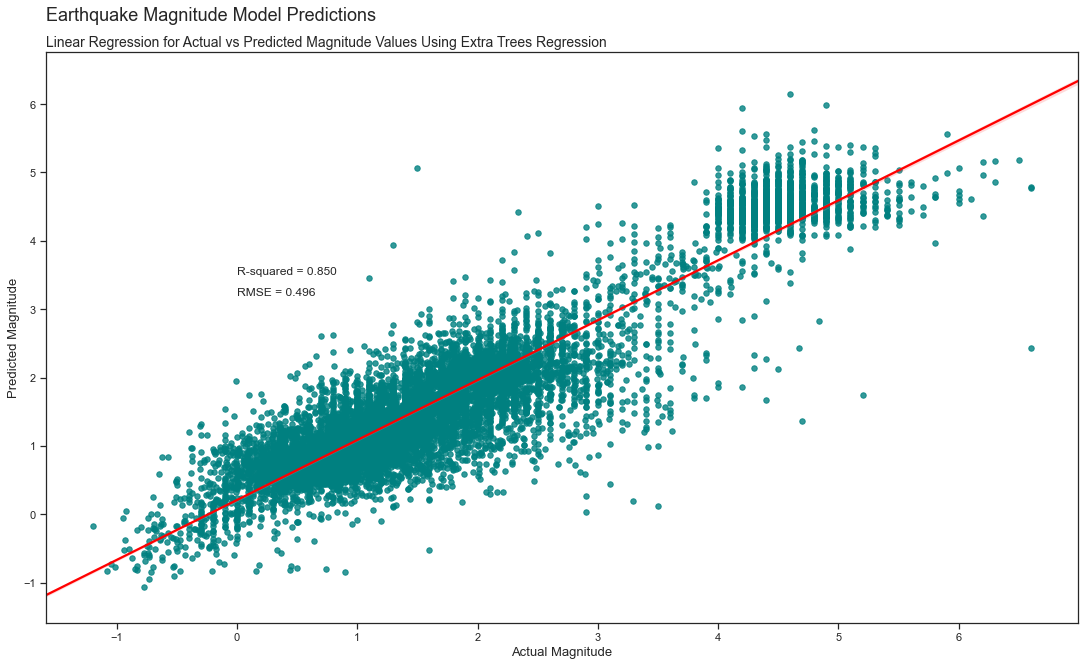

In [29]:
#plot actual vs predicted values
x = np.array(mag_pred_all['mag'])
y = np.array(testpredict)

sns.set_style('ticks')
x,y = pd.Series(x, name="Actual"), pd.Series(y, name="Prediction")
# sns.lmplot(x ='Actual', y ='Prediction', data = mag_pred_all, markers =['o'],  palette ='coolwarm')
ax = sns.regplot(x=x, y=y, ci=95, truncate=False, scatter_kws={"s": 30, "color":'teal'}, line_kws={"color": "red"})
ax.set_axisbelow(True)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.ylabel('Predicted Magnitude', fontsize=13)
plt.xlabel('Actual Magnitude',  fontsize=13)
# Bigger title
plt.suptitle('Earthquake Magnitude Model Predictions', x=0.125, y=0.94, ha='left', fontsize=18)
# Subtitle
plt.title('Linear Regression for Actual vs Predicted Magnitude Values Using Extra Trees Regression', loc='left', fontsize=14)
plt.annotate("R-squared = {:.3f}".format(r2_score(mag_pred_all['mag'], testpredict)), (0, 3.5),  fontsize=12)
plt.annotate("RMSE = {:.3f}".format(rmse), (0, 3.2), fontsize=12)

fig.savefig('../static/images/extratrees_magnotime_linear_sns.png', bbox_inches='tight',dpi=600)
plt.show()

In [31]:
# make a single prediction
from datetime import datetime
lat = float(input('Enter a latitude (in decimal form; negative for southern hemisphere): '))
lon = float(input('Enter a longitude (in decimal form; negative for west of meridian): '))
depth = float(input('Enter a depth (in km, only numerical value): '))
# date_input = input('Enter a date (yyyy/mm/dd): ')
# time_input = input('Enter a time in UTC: ')
# datetime_str = date_input + ' '+ time_input
# date_time_obj = datetime.strptime(datetime_str, '%Y/%m/%d %H:%M:%S')
# date_time_unix = (time.mktime(date_time_obj.timetuple()))
single_features = [[lat,lon,depth]]
y_pred = best_model.predict(single_features)
print('Predicted Magnitude: %g' % y_pred)

Predicted Magnitude: 5.131


Test with new data from USGS

In [32]:
#obtain USGS data for the day
page_url = "https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_day.csv"

test_df = pd.read_csv(page_url)
test_df

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-03-18T01:45:36.470Z,38.822666,-122.766998,2.17,0.87,md,17.0,112.0,0.008119,0.03,...,2022-03-18T01:47:13.931Z,"4km W of Cobb, CA",earthquake,0.29,0.52,0.130,4.0,automatic,nc,nc
1,2022-03-18T01:45:21.900Z,38.790501,-122.725670,1.67,0.86,md,12.0,91.0,0.011280,0.02,...,2022-03-18T01:46:59.070Z,"3km ENE of The Geysers, CA",earthquake,0.28,0.88,0.160,4.0,automatic,nc,nc
2,2022-03-18T01:31:18.440Z,38.752998,-122.696663,0.92,0.85,md,8.0,134.0,0.015290,0.01,...,2022-03-18T01:47:16.734Z,"2km S of Anderson Springs, CA",earthquake,0.36,0.54,0.030,4.0,automatic,nc,nc
3,2022-03-18T01:30:14.790Z,36.083500,-120.137833,12.49,2.18,md,29.0,76.0,0.189800,0.20,...,2022-03-18T01:36:13.674Z,"9km N of Avenal, CA",earthquake,0.51,1.83,0.090,16.0,automatic,nc,nc
4,2022-03-18T01:28:24.311Z,62.339800,-152.330400,116.20,1.90,ml,NaN,NaN,NaN,0.52,...,2022-03-18T01:51:35.712Z,"62 km NW of Skwentna, Alaska",earthquake,NaN,0.80,NaN,NaN,automatic,ak,ak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,2022-03-17T02:31:58.070Z,40.797667,-122.081167,10.22,1.52,md,18.0,55.0,0.032040,0.10,...,2022-03-17T06:26:14.510Z,"12km W of Round Mountain, CA",earthquake,0.37,0.40,0.125,19.0,reviewed,nc,nc
230,2022-03-17T02:20:06.260Z,33.817833,-117.662833,8.23,1.40,ml,52.0,54.0,0.050100,0.17,...,2022-03-17T14:31:12.460Z,"10km WSW of Corona, CA",earthquake,0.17,0.38,0.147,34.0,reviewed,ci,ci
231,2022-03-17T02:19:26.670Z,39.410833,-110.296333,-3.32,1.48,md,6.0,201.0,0.025920,0.10,...,2022-03-17T15:17:47.420Z,"17 km SSE of Sunnyside, Utah",earthquake,1.28,2.62,0.130,6.0,reviewed,uu,uu
232,2022-03-17T02:13:24.216Z,60.917500,-150.867200,34.00,1.60,ml,NaN,NaN,NaN,0.51,...,2022-03-17T02:15:25.596Z,"9 km W of Point Possession, Alaska",earthquake,NaN,0.50,NaN,NaN,automatic,ak,ak


In [33]:
#dropped columns not needed
cleaned_test_df = test_df.drop(columns=['id', 'nst','rms','magNst','net', 'time', 'magType', 'gap','dmin', 'updated', 'place', 'type', 'horizontalError', 'depthError', 'magError', 'status', 'locationSource', 'magSource'])
cleaned_test_df

,latitude,longitude,depth,mag
0,38.822666,-122.766998,2.17,0.87
1,38.790501,-122.725670,1.67,0.86
2,38.752998,-122.696663,0.92,0.85
3,36.083500,-120.137833,12.49,2.18
4,62.339800,-152.330400,116.20,1.90
...,...,...,...,...
229,40.797667,-122.081167,10.22,1.52
230,33.817833,-117.662833,8.23,1.40
231,39.410833,-110.296333,-3.32,1.48
232,60.917500,-150.867200,34.00,1.60


In [34]:
#find if any column has NaNs
cleaned_test_df.isnull().sum()

latitude     0
longitude    0
depth        0
mag          0
dtype: int64

In [35]:
#establish features to be used in model. X will use: latitude, longitude, depth and unix time. Y will be magnitude
X_test_data = cleaned_test_df.drop(['mag'], axis = 1)

y_test_data = cleaned_test_df[['mag']]

In [36]:
#use best model to predict data
pred_data_y = best_model.predict(X_test_data)


In [37]:
#create dataframe with predicted values
test_pred_data = cleaned_test_df
test_pred_data['Predicted'] = pred_data_y
test_pred_data

,latitude,longitude,depth,mag,Predicted
0,38.822666,-122.766998,2.17,0.87,0.8779
1,38.790501,-122.725670,1.67,0.86,0.5439
2,38.752998,-122.696663,0.92,0.85,0.9989
3,36.083500,-120.137833,12.49,2.18,1.8937
4,62.339800,-152.330400,116.20,1.90,1.5020
...,...,...,...,...,...
229,40.797667,-122.081167,10.22,1.52,1.5200
230,33.817833,-117.662833,8.23,1.40,0.8629
231,39.410833,-110.296333,-3.32,1.48,1.4800
232,60.917500,-150.867200,34.00,1.60,1.4120


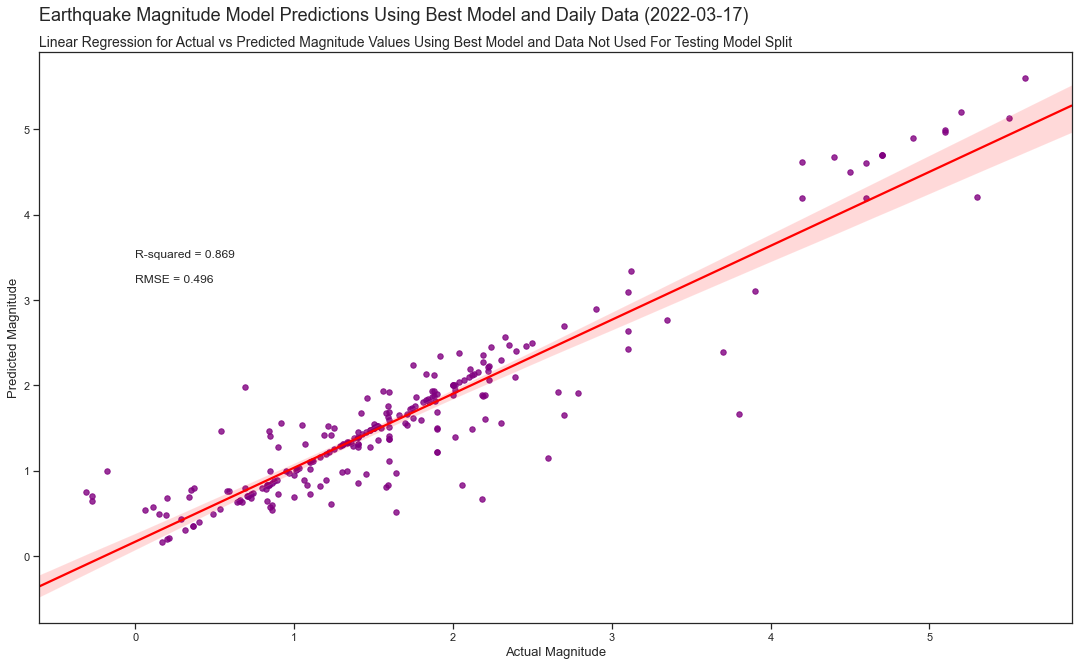

In [38]:
#create grpah for actual vs predicted values
from datetime import date
today = date.today()

x = np.array(test_pred_data['mag'])
y = np.array(pred_data_y)

sns.set_style('ticks')
x,y = pd.Series(x, name="Actual"), pd.Series(y, name="Prediction")
# sns.lmplot(x ='Actual', y ='Prediction', data = mag_pred_all, markers =['o'],  palette ='coolwarm')
ax = sns.regplot(x=x, y=y, ci=95, truncate=False, scatter_kws={"s": 30, "color":'purple'}, line_kws={"color": "red"})
ax.set_axisbelow(True)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.ylabel('Predicted Magnitude', fontsize=13)
plt.xlabel('Actual Magnitude',  fontsize=13)
# Bigger title
plt.suptitle(f'Earthquake Magnitude Model Predictions Using Best Model and Daily Data ({today})', x=0.125, y=0.94, ha='left', fontsize=18)
# Subtitle
plt.title('Linear Regression for Actual vs Predicted Magnitude Values Using Best Model and Data Not Used For Testing Model Split', loc='left', fontsize=14)
plt.annotate("R-squared = {:.3f}".format(r2_score(test_pred_data['mag'], pred_data_y)), (0, 3.5),  fontsize=12)
plt.annotate("RMSE = {:.3f}".format(rmse), (0, 3.2), fontsize=12)

fig.savefig('../static/images/extratrees_magnotime_linear_sns_daily.png', bbox_inches='tight',dpi=600)
plt.show()

In [ ]:
#create new tables in database with training/test dataset test values and predictions

#connection to a PostgreSQL local database
# ===========================================

# user_name_var = input('What is the username of your database? ')
host_var = input('What is the host address of your database?')
pw = input("Enter the database password: ")
# db_name = input("Enter the name of the database: ")

string_output = "postgresql://postgres"+':'+pw+'@'+host_var+":5432"+'/earthquake_db'
engine = create_engine(string_output)
connection = engine.connect()
print("Connected to database...")
#create new database with predicted values for both training and test databases
#=============
#PostgreSQL
mag_pred_all.to_sql('earthquake_etrees_mag_notime', engine, if_exists='replace', index = False)
#=============
#SQLite
cur = conn.cursor()
mag_pred_all.to_sql('earthquake_etrees_mag_notime', conn, if_exists='replace', index=False)
# Close connection to SQLite database
conn.close()
connection.close()